In [2]:
# ruff: disable
"""An example notebook for a data_analysis notebook you may write.

Please use the recommended TNR font unless your venue requires otherwise.
"""

# Write down all of your code for data analysis in this file.
# Plot the data and save the figures/tables in the folders "plots" and "tables"
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from pathlib import Path

# Use TNR for all figures
# to match paper templates
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]

# Whitegrid is most appropriate
# for scientific papers
sns.set_style("whitegrid")

# An optional colorblind palette
# for figures
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]

In [11]:
import wandb

api = wandb.Api()
entity, project = "kornelszabo", "template"
runs = api.runs(entity + "/" + project)
runs = [
    run
    for run in runs
    if ("afl" in run.name and ("compare" in run.name or "noschedule" in run.name))
]

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)

# runs_df.to_csv("project.csv")
runs_df

,summary,config,name
0,"{'_step': 50, '_wandb': {'runtime': 1441}, '_t...","{'fed': {'seed': 5, 'num_rounds': 50, 'rng_fol...",afl_5_noschedule
1,"{'max_train_loss': 0.17283806453148523, 'centr...","{'fed': {'seed': 4, 'num_rounds': 50, 'rng_fol...",afl_4_noschedule
2,"{'_step': 50, 'test_accuracy': 0.5375408262697...","{'fed': {'seed': 3, 'num_rounds': 50, 'rng_fol...",afl_3_noschedule
3,"{'_step': 50, '_wandb': {'runtime': 2089}, '_r...","{'fed': {'seed': 2, 'num_rounds': 50, 'rng_fol...",afl_2_noschedule
4,"{'max_train_loss': 0.05000166048441401, 'train...","{'fed': {'seed': 1, 'num_rounds': 50, 'rng_fol...",afl_1_noschedule
5,"{'distributed_loss': 0.27873651645912645, '_st...","{'fed': {'seed': 5, 'num_rounds': 50, 'rng_fol...",afl_5_compare
6,"{'_step': 50, '_wandb': {'runtime': 2277}, 'la...","{'fed': {'seed': 4, 'num_rounds': 50, 'rng_fol...",afl_4_compare
7,"{'_runtime': 2041.5774199962616, 'train_loss':...","{'fed': {'seed': 3, 'num_rounds': 50, 'rng_fol...",afl_3_compare
8,"{'max_train_loss': 0.04759770710432776, 'distr...","{'fed': {'seed': 2, 'num_rounds': 50, 'rng_fol...",afl_2_compare
9,"{'_wandb': {'runtime': 2016}, 'lambdas': {'0':...","{'fed': {'seed': 1, 'num_rounds': 50, 'rng_fol...",afl_1_compare


In [12]:
def get_artifact(run):
    path = Path("./artifacts/mapping/") / run.name
    if path.exists():
        mapping = pd.read_csv(path)
        data = mapping[run.name].item()
    else:
        artifact = run.logged_artifacts()
        if len(artifact) == 0:
            return pd.DataFrame()
        data = artifact[0].download()
        pd.DataFrame([data], columns=[run.name]).to_csv(path)
    return pd.read_parquet(data)

In [14]:
artifacts = {}
for run in runs:
    if run.name not in artifacts:
        artifacts[run.name] = get_artifact(run)

wandb:   1 of 1 files downloaded.  
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb:   1 of 1 files downloaded.  
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb:   1 of 1 files downloaded.  
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb:   1 of 1 files downloaded.  
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb:   1 of 1 files downloaded.  
wandb: WARNING Source ty

In [17]:
dfx = runs_df.assign(
    model=lambda df: df.name.apply(lambda row: row.split("_")[-1])
).set_index("model")

dfy = dfx.assign(
    train_acc=lambda df: df.summary.apply(lambda row: row["train_accuracy"]),
    test_acc=lambda df: df.summary.apply(lambda row: row["test_accuracy"]),
    test_acc_max=lambda df: df.name.apply(
        lambda name: artifacts[name].test_accuracy.max().item()
    ),
    # test_acc_max=lambda df: df.summary.apply(lambda row: row['test_accuracy'].max()),
)

dfy = dfy.rename(lambda name: name if name != "compare" else "schedule", axis=0)

dfy

,summary,config,name,train_acc,test_acc,test_acc_max
model,,,,,,
noschedule,"{'_step': 50, '_wandb': {'runtime': 1441}, '_t...","{'fed': {'seed': 5, 'num_rounds': 50, 'rng_fol...",afl_5_noschedule,0.953915,0.469330,0.648469
noschedule,"{'max_train_loss': 0.17283806453148523, 'centr...","{'fed': {'seed': 4, 'num_rounds': 50, 'rng_fol...",afl_4_noschedule,0.959021,0.552439,0.645493
noschedule,"{'_step': 50, 'test_accuracy': 0.5375408262697...","{'fed': {'seed': 3, 'num_rounds': 50, 'rng_fol...",afl_3_noschedule,0.865498,0.537541,0.564122
noschedule,"{'_step': 50, '_wandb': {'runtime': 2089}, '_r...","{'fed': {'seed': 2, 'num_rounds': 50, 'rng_fol...",afl_2_noschedule,0.974713,0.521331,0.680252
noschedule,"{'max_train_loss': 0.05000166048441401, 'train...","{'fed': {'seed': 1, 'num_rounds': 50, 'rng_fol...",afl_1_noschedule,0.972620,0.408835,0.565100
schedule,"{'distributed_loss': 0.27873651645912645, '_st...","{'fed': {'seed': 5, 'num_rounds': 50, 'rng_fol...",afl_5_compare,0.908315,0.347500,0.499900
schedule,"{'_step': 50, '_wandb': {'runtime': 2277}, 'la...","{'fed': {'seed': 4, 'num_rounds': 50, 'rng_fol...",afl_4_compare,0.959021,0.533200,0.588700
schedule,"{'_runtime': 2041.5774199962616, 'train_loss':...","{'fed': {'seed': 3, 'num_rounds': 50, 'rng_fol...",afl_3_compare,0.865498,0.537541,0.564122
schedule,"{'max_train_loss': 0.04759770710432776, 'distr...","{'fed': {'seed': 2, 'num_rounds': 50, 'rng_fol...",afl_2_compare,0.974713,0.521331,0.680100


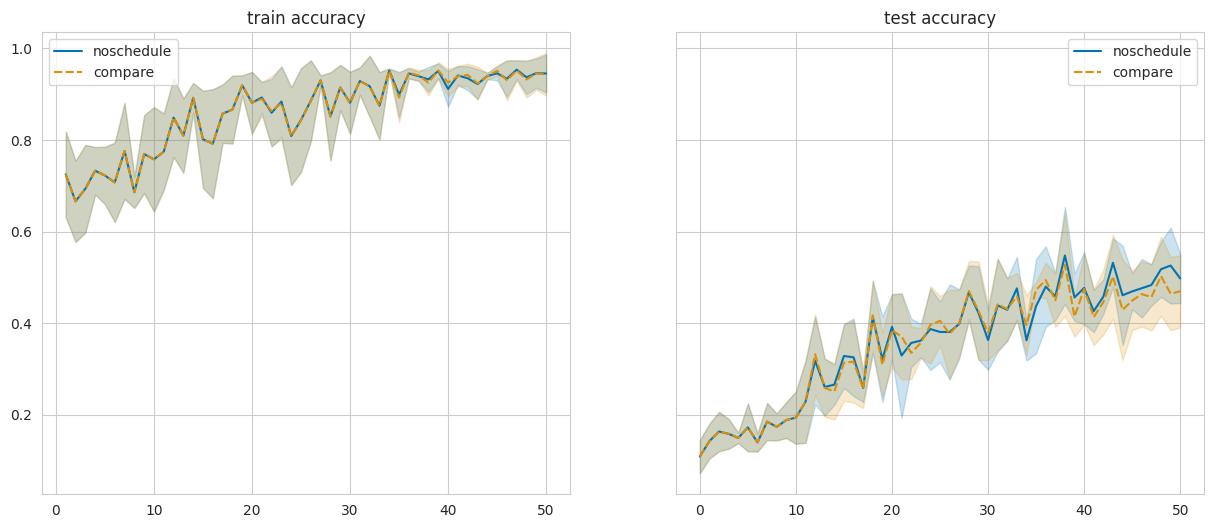

In [19]:
train = pd.DataFrame(
    np.array([v.train_accuracy.values for v in artifacts.values()]).T,
    columns=[name.split("_")[-1] for name in artifacts],
)

test = pd.DataFrame(
    np.array([v.test_accuracy.values for v in artifacts.values()]).T,
    columns=[name.split("_")[-1] for name in artifacts],
)

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.lineplot(train, errorbar="sd", palette="colorblind", ax=ax[0]).set_title(
    "train accuracy"
)
sns.lineplot(test, errorbar="sd", palette="colorblind", ax=ax[1]).set_title(
    "test accuracy"
)


plt.savefig("./plots/exp_2.png", bbox_inches="tight")

In [ ]:
x = dfy.groupby("model").agg({"test_acc": ["mean", "std"]}).round(2)

print(x.droplevel(axis=1, level=0).T.to_latex())

\begin{tabular}{lrrrr}
\toprule
model & afl & fedadagrad & fedadam & fedavg \\
\midrule
mean & 0.470000 & 0.660000 & 0.410000 & 0.510000 \\
std & 0.090000 & 0.170000 & 0.090000 & 0.040000 \\
\bottomrule
\end{tabular}



In [ ]:
for model in ["fedavg", "fedadam", "fedadagrad"]:
    print(
        f"{model}: {scipy.stats.ttest_ind(dfy.loc['afl'].test_acc, dfy.loc[model].test_acc).pvalue}"
    )

fedavg: 0.3412595364907857
fedadam: 0.36053439795902625
fedadagrad: 0.5976265089514131
